In [56]:
import pandas as pd
import numpy as np
import sys
import os

# Allows to get the module in utils
sys.path.append(os.path.abspath(".."))


from utils.load import load_data
from utils.preprocessing import preprocess
from utils.split import split_data

from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
# from sklearn.compose import ColumnTransformer

import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

In [42]:
# Load data
df = load_data()

In [43]:
# Split and preprocess datas set
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)

X_train_processed, X_test_processed, X_val_processed, y_test_encoding, y_train_encoded, y_val_encoding, pipeline, le = preprocess(X_train, X_val, X_test, y_train, y_val, y_test)

/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [44]:
X_train_dense = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_val_dense = X_val_processed.toarray() if hasattr(X_val_processed, "toarray") else X_val_processed
X_test_dense = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

In [45]:
y_train_vector = y_train_encoded.reshape(-1)
y_val_vector = y_val_encoding.reshape(-1)
y_test_vector = y_test_encoding.reshape(-1)

In [54]:
input_dim = X_train_dense.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall', 'auc']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │       290,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 294,593 (1.12 MB)

 Trainable params: 294,593 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

# Conversion en dict attendu par Keras
class_weights = dict(enumerate(class_weights))

history = model.fit(
    X_train_dense, y_train_vector,
    validation_data=(X_val_dense, y_val_vector),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7436 - auc: 0.7291 - loss: 0.5748 - recall: 0.2211 - val_accuracy: 0.7347 - val_auc: 0.7780 - val_loss: 0.5328 - val_recall: 0.0000e+00
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7558 - auc: 0.8245 - loss: 0.4383 - recall: 0.4243 - val_accuracy: 0.7941 - val_auc: 0.8174 - val_loss: 0.4971 - val_recall: 0.6421
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8331 - auc: 0.8861 - loss: 0.3502 - recall: 0.7809 - val_accuracy: 0.7240 - val_auc: 0.8006 - val_loss: 0.5137 - val_recall: 0.7793
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9093 - auc: 0.9560 - loss: 0.2389 - recall: 0.8771 - val_accuracy: 0.7028 - val_auc: 0.7712 - val_loss: 0.5760 - val_recall: 0.7659
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9458 - auc: 0.9756 - loss: 0.1517 - recall: 0.9491 - val_accuracy: 0.6158 - val_auc: 0.6670 - val_loss: 0.7511 - val_recall: 0.5518
Epoch 

# Rating

In [48]:
test_loss, test_acc = model.evaluate(X_test_dense, y_test_vector, verbose=0)
print(f"\nAccuracy sur le test set : {test_acc:.4f}")


Accuracy sur le test set : 0.5834


In [49]:
y_pred_probs = model.predict(X_test_dense)
y_pred = np.argmax(y_pred_probs, axis=1)
print("\nClassification Report :")
print(classification_report(y_test_vector, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report :
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409



/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicte

In [50]:
y_pred_probs = model.predict(X_test_dense)
y_pred = np.argmax(y_pred_probs, axis=1)
print("\nClassification Report :")
print(classification_report(y_test_vector, y_pred))


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Classification Report :
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409



/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicte

In [51]:
print("Matrice de Confusion :")
cm = confusion_matrix(y_test_vector, y_pred)
print(cm)

Matrice de Confusion :
[[1035    0]
 [ 374    0]]


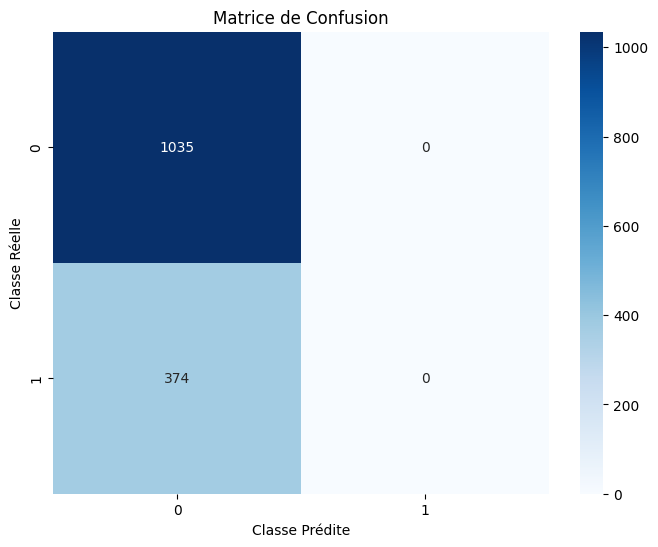

In [52]:

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.show()

# Visualization of the training curves

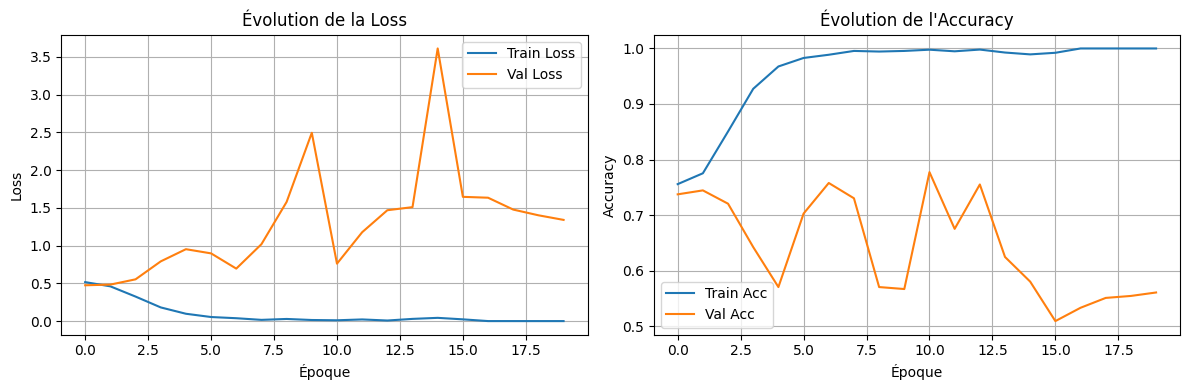

In [53]:
def plot_loss_acc(history, validation=True):
    """
    Trace la loss et l'accuracy du modèle pendant l'entraînement.
    """
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if validation and 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if validation and 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Évolution de l'Accuracy")
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_loss_acc(history)